In [1]:
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt

from scipy.ndimage.filters import convolve,correlate,median_filter

In [1]:
def bnw(x,y):
    #Rounding
    x1 = np.floor(x)
    x2 = np.ceil(x)
    
    y1 = np.floor(y)
    y2 = np.ceil(y)
    
    #Compute weights
    if x2-x1 != 0:
        w11 = (x2-x)/(x2-x1)
        w12 = (x-x1)/(x2-x1)
        w21 = (x2-x)/(x2-x1)
        w22 = (x-x1)/(x2-x1)
    else:
        w11 = 1
        w12 = 1
        w21 = 1
        w22 = 1
        
    if y2-y1 != 0:
        w11 *= (y2-y)/(y2-y1)
        w12 *= (y2-y)/(y2-y1)
        w21 *= (y-y1)/(y2-y1)
        w22 *= (y-y1)/(y2-y1)
    else:
        w11 *= 1
        w12 *= 1
        w21 *= 1
        w22 *= 1
    
    return w11,w12,w21,w22

def LBP(I,N,R):
    ks = 2*(R+1)+1
    c = R+1
    kernel = np.zeros((ks,ks))
    filterbank = []
    theta = np.linspace(0,N-1,N)
    theta *= 2*np.pi/N
    for k in range(N):
        
        #Set center to -1
        _krnl = kernel.copy()
        
        #Compute neighbour coordinates
        x = R*np.cos(theta[k])
        y = R*np.sin(theta[k])
                
        x1 = int(np.floor(x))
        x2 = int(np.ceil(x))
        y1 = int(np.floor(y))
        y2 = int(np.ceil(y))
        
        #Compute interpolation weights
        w11,w12,w21,w22 = bnw(x,y)
        
        #Insert weights to kernel
        _krnl[c+y1,c+x1] = w11
        _krnl[c+y1,c+x2] = w12
        _krnl[c+y2,c+x1] = w21
        _krnl[c+y2,c+x2] = w22
                
        #Append kernel to list
        filterbank.append(_krnl)
        
    #Compute lbp
    lbp = []
    for k in range(len(filterbank)):
        _lbp = correlate(I,filterbank[k])-I
        _lbp = _lbp
        _lbp = (_lbp>=1e-6)*1.0
        lbp.append(_lbp)
        
    #LBP to numpy array, channels to 3rd axis
    lbp = np.array(lbp)
    lbp = np.swapaxes(lbp,0,2)
    
    lbpI = np.zeros(lbp[:,:,0].shape)
    for k in range(lbp.shape[2]):
        lbpI += lbp[:,:,k]*2**(lbp[:,:,k]*k)
    
    return lbp,lbpI

def MRELBP(I,N,R,r,wc,wR,wr, mode='hist'):
    Ic = median_filter(I,wc)
    IR = median_filter(I,wR)
    Ir = median_filter(I,wr)
    
    #kernel weigths
    f1 = []
    f2 = []
    
    ks = 2*(R+1)+1
    c = R+1
    kernel = np.zeros((ks,ks))
    theta = np.linspace(0,N-1,N)
    theta *= 2*np.pi/N
    
    #Kernels
    for k in range(N):
        #Large radius
        
        _krnl = kernel.copy()
        
        #Compute neighbour coordinates
        x = R*np.cos(theta[k])
        y = R*np.sin(theta[k])
                
        x1 = int(np.floor(x))
        x2 = int(np.ceil(x))
        y1 = int(np.floor(y))
        y2 = int(np.ceil(y))
        
        
        #Compute interpolation weights
        w11,w12,w21,w22 = bnw(x,y)
        
        #Insert weights to kernel
        _krnl[c+y1,c+x1] = w11
        _krnl[c+y1,c+x2] = w12
        _krnl[c+y2,c+x1] = w21
        _krnl[c+y2,c+x2] = w22
                
        #Append kernel to list
        f1.append(_krnl)
        
        #Small radius
        
        _krnl = kernel.copy()
        
        #Compute neighbour coordinates
        x = r*np.cos(theta[k])
        y = r*np.sin(theta[k])
                
        x1 = int(np.floor(x))
        x2 = int(np.ceil(x))
        y1 = int(np.floor(y))
        y2 = int(np.ceil(y))
        
        
        #Compute interpolation weights
        w11,w12,w21,w22 = bnw(x,y)
        
        #Insert weights to kernel
        _krnl[c+y1,c+x1] = w11
        _krnl[c+y1,c+x2] = w12
        _krnl[c+y2,c+x1] = w21
        _krnl[c+y2,c+x2] = w22
                
        #Append kernel to list
        f2.append(_krnl)
        
    #Compute lbps
    lbpR = []
    lbpr = []
    lbpD = []
    for k in range(len(f1)):
        _lbpR = correlate(I,f1[k])-Ic
        _lbpR = (_lbpR>=1e-6)*1.0
        lbpR.append(_lbpR)
        _lbpr = correlate(I,f2[k])-Ic
        _lbpr = (_lbpr>=1e-6)*1.0
        lbpr.append(_lbpr)
        _lbpD = _lbpR-_lbpr
        _lbpD = (_lbpD>=1e-6)*1.0
        lbpD.append(_lbpD)
        
    #LBP to numpy array, channels to 3rd axis
    lbpR = np.array(lbpR)
    lbpR = np.swapaxes(lbpR,0,2)
    
    lbpr = np.array(lbpR)
    lbpr = np.swapaxes(lbpR,0,2)
    
    lbpD = np.array(lbpD)
    lbpD = np.swapaxes(lbpD,0,2)
    
    lbpIR = np.zeros(lbpR[:,:,0].shape)
    lbpIr = np.zeros(lbpr[:,:,0].shape)
    lbpID = np.zeros(lbpD[:,:,0].shape)
    
    for k in range(lbpR.shape[2]):
        lbpIR += lbpR[:,:,k]*2**k
        lbpIr += lbpr[:,:,k]*2**k
        lbpID += lbpD[:,:,k]*2**k
        
    #histograms
    histR = np.zeros((2**N,1))
    histr = np.zeros((2**N,1))
    histD = np.zeros((2**N,1))
    
    for k in range(2**N):
        _tmp = (lbpIR==k)*1.0
        histR[k] += _tmp.sum()
        _tmp = (lbpIr==k)*1.0
        histr[k] += _tmp.sum()
        _tmp = (lbpID==k)*1.0
        histD[k] += _tmp.sum()
    
    lbpc = (Ic-Ic.mean())>=1e-6
    
    histc = np.zeros((2,1))
    histc[0,0] = np.sum((lbpc==0)*1.0)
    histc[1,0] = np.sum((lbpc==1)*1.0)
    
    if mode == 'hist':
        return histc,histR,histr,histD
    else:
        return lbpc,lbpIR,lbpIr,lbpID
    
    #Mapping
def getmapping(N):
    #Defines rotation invariant uniform mapping for lbp of N neighbours	
    newMax = N + 2
    table = np.zeros((1,2**N))
    for k in range(2**N):
        #Binary representation of bin number
        binrep = np.binary_repr(k,N)
        #Convert string to list of digits
        i_bin = np.zeros((1,len(binrep)))
        for ii in range(len(binrep)):
            i_bin[0,ii] = int(float(binrep[ii]))
        #Rotation
        j_bin = np.roll(i_bin,-1)
        #uniformity
        numt = np.sum(i_bin!=j_bin)
        #Binning
        if numt <= 2:
            b = np.binary_repr(k,N)
            c=0
            for ii in range(len(b)):
                c = c+int(float(b[ii]))
            table[0,k] = c
        else:
            table[0,k] = N+1
    #num = newMax
    return table

#Apply mapping to lbp
def maplbp(bin,mapping):
    #Applies mapping to lbp bin
    #Number of bins in output
    N = int(np.max(mapping))
    #Empty array
    outbin = np.zeros((1,N+1))
    for k in range(N+1):
        #RIU indices
        M = mapping==k
        #Extract indices from original bin to new bin
        outbin[0,k] = np.sum(M*bin)
    return outbin

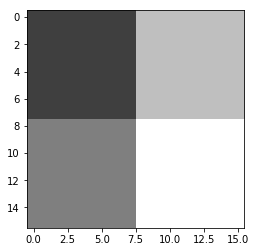

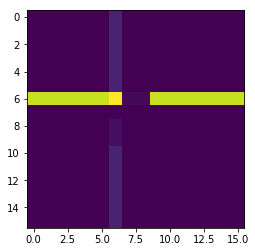

(16, 16)


In [4]:
I11 = np.ones((8,8))
I12 = np.ones((8,8))*2
I21 = np.ones((8,8))*3
I22 = np.ones((8,8))*4

I1 = np.concatenate((I11,I12),0)
I2 = np.concatenate((I21,I22),0)

I = np.concatenate((I1,I2),1)

image = I.reshape(I.shape[0],I.shape[1],1)
image = np.concatenate((image,image,image),2)/4

plt.imshow(image)
plt.show()

#I,N,R,r,wc,wR,wr, mode=='hist'
bpc,bpR,bpr,bpD = MRELBP(I,8,2,1,5,5,5,mode='imag')

plt.imshow(bpD/bpD.max())
plt.show()
print(np.shape(bpD))
#for k in range(bpD.shape[2]):
#    im = bpD[:,:,k]
#    D = im.shape
#    im = im.reshape(D[0],D[1],1)
#    im = np.concatenate((im,im,im),2)
#    plt.imshow(im)
#    plt.show()
#    print(im.shape)

In [ ]:
np.linspace(0,360-360/8,8)